## import os 

In [1]:
import os
os.listdir()

['train.csv',
 'DataCleaning.ipynb',
 'EDA.ipynb',
 'PA_201605-2012001更新R6(20190509).xlsx',
 'tag盤點表.xlsx',
 'xgboost.ipynb',
 'LSTM.ipynb',
 'train_FeatureSelected.csv',
 'feature select.ipynb',
 'tpot_pa_pipeline.py',
 'TPOT.ipynb',
 'cnn-time-stack.ipynb',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# load

In [3]:
df = pd.read_csv('train_FeatureSelected.csv',index_col = 0,parse_dates = True)
print(df.shape)
df.head()

(122775, 16)


,MLPAP_TI-0706B10,MLPAP_TI-0706B15,MLPAP_TI-0706B21,MLPAP_TI-0716A03,MLPAP_TI-0716A05,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TI-0706B01,MLPAP_TRC-0610.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,-0.883078,0.436520,0.527857,2.885848,0.448321,0.677295,0.881300,0.796872,0.633992,3.036852,3.099501,0.608934,-2.619894,-1.015438,-0.088287,0.914125
2016-05-10 08:20:00,-0.883078,0.436520,0.527857,2.885848,0.448321,0.677122,0.881648,0.797089,0.633992,2.864041,3.272350,0.447358,-2.614712,-0.982340,-0.088287,0.919765
2016-05-10 08:30:00,-0.883078,0.436830,0.527857,2.885848,0.448321,0.677619,0.881571,0.796987,0.633992,3.006620,3.596289,-0.634915,-2.617016,-0.975999,-0.088287,0.926346
2016-05-10 23:40:00,-1.508446,0.411821,0.395807,2.856863,0.468480,0.641630,0.853312,0.763786,0.601863,1.710665,3.361869,0.769126,-2.612469,-0.840360,-0.088287,0.906781
2016-05-10 23:50:00,-1.443246,0.412131,0.395807,2.882331,0.468480,0.642077,0.853810,0.764300,0.603356,1.822449,3.029603,0.528846,-2.620588,-0.868595,-0.088287,0.926688


# scale

In [4]:
from sklearn.preprocessing import MinMaxScaler

x_col = df.drop('target',axis=1).columns.tolist()
y_col = 'target'

sc = MinMaxScaler()
df[x_col] = sc.fit_transform(df[x_col])

df.head()

,MLPAP_TI-0706B10,MLPAP_TI-0706B15,MLPAP_TI-0706B21,MLPAP_TI-0716A03,MLPAP_TI-0716A05,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TI-0706B01,MLPAP_TRC-0610.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_FR-0755.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2016-05-10 08:10:00,0.803927,0.968352,0.990723,1.000000,0.977663,0.693540,0.999851,0.999915,1.000000,0.870333,0.564397,0.517157,0.091998,0.909638,0.145161,0.914125
2016-05-10 08:20:00,0.803927,0.968352,0.990723,1.000000,0.977663,0.693497,1.000000,1.000000,1.000000,0.855041,0.572776,0.504635,0.092996,0.910421,0.145161,0.919765
2016-05-10 08:30:00,0.803927,0.968465,0.990723,1.000000,0.977663,0.693619,0.999967,0.999960,1.000000,0.867657,0.588480,0.420763,0.092552,0.910572,0.145161,0.926346
2016-05-10 23:40:00,0.757022,0.959309,0.983765,0.999050,0.981970,0.684815,0.987892,0.986978,0.988840,0.752979,0.577116,0.529571,0.093428,0.913783,0.145161,0.906781
2016-05-10 23:50:00,0.761912,0.959423,0.983765,0.999885,0.981970,0.684924,0.988105,0.987179,0.989358,0.762871,0.561009,0.510950,0.091865,0.913115,0.145161,0.926688


# stack

In [5]:
def train_windows(df, ref_day=15, predict_day=1):
    X_train, Y_train, i_lst = [], [], []
    for i in tqdm(range(df.shape[0]-predict_day-ref_day)):
        X_train.append(np.array(df.iloc[i:i+ref_day][x_col]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day][y_col]))
        i_lst.append(df.iloc[i+ref_day:i+ref_day+predict_day].index[0])
    return np.array(X_train), np.array(Y_train), i_lst

In [6]:
X, y, i_lst = train_windows(df, ref_day=15, predict_day=1)
print(len(X),len(y),len(i_lst))

/workspace/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



122759 122759 122759


In [7]:
y = pd.Series(y.ravel(),index=i_lst,name='y')
y.head()

2016-05-13 15:00:00    0.903952
2016-05-13 15:10:00    0.888240
2016-05-13 15:20:00    0.894072
2016-05-13 15:30:00    0.889203
2016-05-13 15:40:00    0.928332
Name: y, dtype: float64

# Visualization

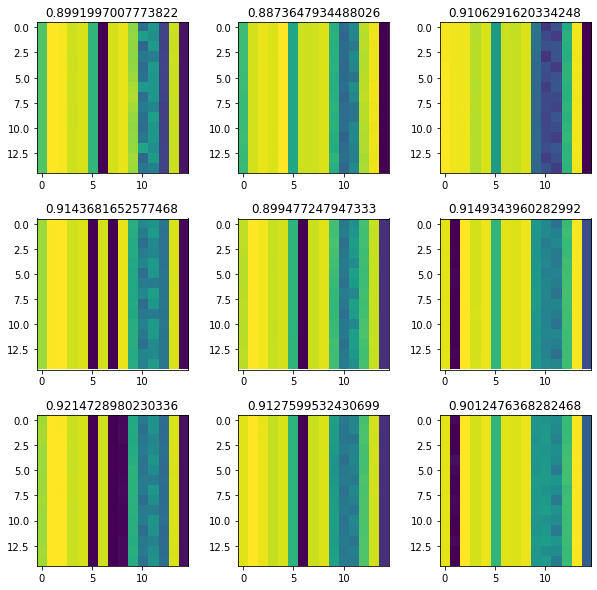

In [8]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    idx = np.random.randint(0,len(X))
    plt.imshow(X[idx])
    plt.title(y[idx])

# reshape

In [9]:
X = X.reshape(-1,15,15,1)
print(X.shape,y.shape)

(122759, 15, 15, 1) (122759,)


# split

In [10]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 7)
X_val, X_test ,y_val ,y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 7)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(85931, 15, 15, 1) (85931,)
(18414, 15, 15, 1) (18414,)
(18414, 15, 15, 1) (18414,)


# Model

In [11]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam
import warnings;warnings.simplefilter('ignore')

Using TensorFlow backend.
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/workspace/conda/lib/python3.6/site-packages/tensorflow/python/framework/d

In [12]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=X[0].shape))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total para

In [13]:
model.compile(optimizer=Adam(lr=0.0001), loss="mse", metrics=["mse"])

In [14]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,mode='min')

# fit

In [15]:
history = model.fit(X_train,y_train,
                    batch_size = 256,
                    epochs = 100,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks = [es])

Train on 85931 samples, validate on 18414 samples
Epoch 1/100
85931/85931 [==============================] - 5s 57us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 1.7011e-04 - val_mean_squared_error: 1.7011e-04
Epoch 2/100
85931/85931 [==============================] - 2s 19us/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 1.1509e-04 - val_mean_squared_error: 1.1509e-04
Epoch 3/100
85931/85931 [==============================] - 2s 19us/step - loss: 9.7792e-04 - mean_squared_error: 9.7792e-04 - val_loss: 1.1546e-04 - val_mean_squared_error: 1.1546e-04
Epoch 4/100
85931/85931 [==============================] - 2s 19us/step - loss: 7.0926e-04 - mean_squared_error: 7.0926e-04 - val_loss: 1.4265e-04 - val_mean_squared_error: 1.4265e-04
Epoch 5/100
85931/85931 [==============================] - 2s 19us/step - loss: 5.7981e-04 - mean_squared_error: 5.7981e-04 - val_loss: 9.4412e-05 - val_mean_squared_error: 9.4412e-05
Epoch 6/100
85931/85931 [=====================

# eval

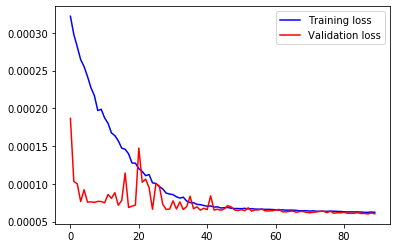

In [16]:
n = 10
plt.plot(history.history['loss'][n:], color='b', label="Training loss")
plt.plot(history.history['val_loss'][n:], color='r', label="Validation loss")
plt.legend()

In [17]:
from sklearn.metrics import r2_score,mean_squared_error

y_pred = model.predict(X_test).ravel()
print(round(r2_score(y_test,y_pred),4))
print(round(mean_squared_error(y_test,y_pred),4))

0.3431
0.0001


In [20]:
y_pred = pd.Series(y_pred,index=y_test.index,name='y_pred')

In [21]:
y_pred = y_pred.sort_index()
y_test = y_test.sort_index()

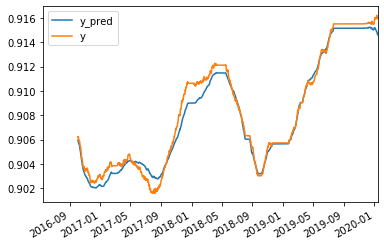

In [25]:
y_pred.rolling(6*24*15).mean().plot()
y_test.rolling(6*24*15).mean().plot()
plt.legend()
plt.show()